<a href="https://colab.research.google.com/github/kuperov/pcv_rev/blob/revisions/Example%203%20-%20Radon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

## Dependencies & environment

In [1]:
%pip install --upgrade pip
# # freeze blackjax to the last commit as of the time of writing
%pip install -q git+https://github.com/blackjax-devs/blackjax.git@7100bca3ea39def4bbeaa179a015f67abfa0b1f0
%pip install --upgrade -q git+https://github.com/kuperov/welford.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
from jax.config import config
config.update("jax_enable_x64", True)
import jax
from jax import numpy as jnp
for i, d in enumerate(jax.devices()):
  print(f"Device {i}. {d.device_kind} ({d.platform}{d.id})")

<ipython-input-2-b5962bd53053>:1: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


Device 0. Tesla V100-SXM2-16GB (gpu0)


In [3]:
#@title Inference procedures

import blackjax as bj
assert bj.__version__ == "0.9.7.dev153+g7100bca"
from blackjax.mcmc.hmc import HMCState

import zipfile
import json
import jax
import jax.numpy as jnp
from jax.scipy import stats
import arviz as az
from jax.scipy.special import logsumexp
from tensorflow_probability.substrates import jax as tfp
from typing import NamedTuple, Dict, Callable, Tuple
import welford as wf
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib import ticker
from tqdm.notebook import tqdm
import pickle
import time
import seaborn as sns
sns.set_context('paper')
sns.set_style('ticks')
sns.set_palette('colorblind')
tfd = tfp.distributions
tfb = tfp.bijectors

@partial(jax.jit, static_argnames=['mip', 'ljd'], backend='cpu')
def find_initial_params(rng_key, mip, ljd, adam_iter, adam_lr):
    """Use adam to approximately maximize the log joint density.

    Args:
        rng_key: random state
        mip: function to make initial position, which takes a key and should be a random prior draw
        ljd: log joint density function
        adam_iter: iterations
        adam_lr: learning rate
    """
    import optax
    params = mip(rng_key)
    optimizer = optax.adam(learning_rate=adam_lr)
    f = lambda x: -ljd(x)
    state = optimizer.init(params)
    def loop_body(i, carry):
        params, state = carry
        _, grads = jax.value_and_grad(f)(params)
        updates, new_state = optimizer.update(grads, state)
        new_params = optax.apply_updates(params, updates)
        return new_params, new_state
    params, _ = jax.lax.fori_loop(0, adam_iter, loop_body, (params, state))
    return params

class ExtendedState(NamedTuple):
    """MCMC state--extends regular HMC state variable--also includes batch welford accumulators"""
    state: HMCState  # current HMC state
    rng_key: jax.random.KeyArray  # current random seed
    pred_ws: wf.LogWelfordState  # accumulator for log predictive
    pred_bws: wf.BatchLogWelfordState  # batch accumulator for log predictive, size b
    divergences: jax.Array  # divergence counts (int array)

class Model(NamedTuple):
    logjoint_density: Callable
    log_pred: Callable
    make_initial_pos: Callable
    to_constrained: Callable
    priors: Dict[str, tfd.Distribution]
    Theta: object


class ExtendedState(NamedTuple):
    """MCMC state--extends regular HMC state variable--also includes batch welford accumulators"""
    state: HMCState  # current HMC state
    rng_key: jax.random.KeyArray  # current random seed
    divergences: jax.Array  # divergence counts (int array)


class MCMCResults(NamedTuple):
    model: Model
    fold_id: int
    trace: object  # model.Theta
    adapt_res: bj.kernels.AdaptationResults

    def arviz(self):
        """Turn trace into an Arviz object
        """
        # compute predictive draws: dims (draw, chain)
        lp_draws = jax.vmap(jax.vmap(lambda x: self.model.log_pred(x, self.fold_id)))(self.trace)  # use unconstrained variables
        # transform back to constrained parameter space
        constrained_trace = jax.vmap(self.model.to_constrained)(self.trace)
        _params = {v : constrained_trace[i] for i, v in enumerate(self.trace._fields)}
        _params['log_pred'] = lp_draws
        _params['scaled_pred'] = jnp.exp(lp_draws - jnp.max(lp_draws))
        return az.convert_to_inference_data(_params)


def full_trace_inference(
    model: Model,
    fold_id,
    inference_key,
    num_integration_steps,
    num_chains,
    iter,
    warmup_iter,
    adapt_iter,
    adam_iter,
    adam_lr):
    """Single-model, single fold MCMC inference
    """

    def init_ext_state(state, rng_key):
        """Create initial state"""
        return ExtendedState(
            state=state,
            rng_key=rng_key,
            divergences=jnp.array(0, dtype=jnp.int32),
        )

    def reset_ext_state(state):
        """Reset averages after warmup"""
        return ExtendedState(
            state=state.state,
            rng_key=state.rng_key,
            divergences=jnp.array(0, dtype=jnp.int32),
        )

    @partial(jax.jit, static_argnames=['num_samples'], backend='cpu')
    def single_inference_loop(ext_states, fold_id, num_samples) -> Tuple[ExtendedState, HMCState]:
        hmc = bj.hmc(lambda x: model.logjoint_density(x, fold_id), **adapt_res.parameters)
        def one_chain_inference_loop(state):  # Single chain inference loop
            def one_mcmc_step(ext_state: ExtendedState, _idx)  -> Tuple[ExtendedState, HMCState]:
                # Single chain, single MCMC step.
                iter_key, carry_key = jax.random.split(ext_state.rng_key)
                chain_state, chain_info = hmc.step(iter_key, ext_state.state)
                #elpd_contrib = model.log_pred(chain_state.position, fold_id)
                carry_state = ExtendedState(
                    state=chain_state,
                    rng_key=carry_key,
                    divergences=ext_state.divergences + chain_info.is_divergent,
                )
                return carry_state, chain_state.position
            next_state, trace = jax.lax.scan(one_mcmc_step, state, jnp.arange(num_samples))
            return next_state, trace
        # run all chains for this fold in parallel
        return jax.vmap(one_chain_inference_loop)(ext_states)

    start_at = time.time()

    state_k, sampling_k, adapt_k = jax.random.split(inference_key, 3)
    # parameter adaptation
    fd_ljd = lambda x: model.logjoint_density(x, fold_id)
    init_pos_1c = find_initial_params(state_k, model.make_initial_pos, fd_ljd, adam_iter, adam_lr)
    adapt = bj.window_adaptation(
        bj.hmc,
        fd_ljd,
        num_integration_steps=num_integration_steps,
        progress_bar=True)
    adapt_res, _ = adapt.run(adapt_k, init_pos_1c, num_steps=adapt_iter)
    print(f"Step size = {adapt_res.parameters['step_size']:.4f}, inv mm norm = {jnp.linalg.norm(adapt_res.parameters['inverse_mass_matrix']):.4f}")

    fm_hmc = bj.hmc(lambda x: model.logjoint_density(x, fold_id), **adapt_res.parameters)
    state_ks = jax.random.split(state_k, num_chains)
    ljd = lambda x: model.logjoint_density(x, fold_id)
    init_pos = lambda k: find_initial_params(k, model.make_initial_pos, ljd, adam_iter, adam_lr)
    fm_init_pos = jax.vmap(init_pos)(state_ks)
    fm_init_hmcstates = jax.vmap(fm_hmc.init)(fm_init_pos)
    initstate = jax.vmap(init_ext_state)(fm_init_hmcstates, jax.random.split(sampling_k, num_chains))

    # final warm-up step
    print("Warm-up sampling run")
    state, _ = single_inference_loop(initstate, fold_id, warmup_iter)
    state = jax.vmap(reset_ext_state)(state)  # discard values accumulated during burn-in
    print(f"Warmup complete in {time.time() - start_at:.2f} sec")

    print("Sampling")
    start_at = time.time()
    state, trace = single_inference_loop(state, fold_id, iter)
    if state.divergences.sum() > 0:
        print(f"{state.divergences.sum()} divergences seen during inference")
    print(f"Done in {time.time() - start_at:.2f} sec")

    return MCMCResults(model, fold_id, trace, adapt_res)

def logvar(lxs, ddof=0, axis=None):
    # compute log(var(m*exp(x))/m^2) = log(var(exp(x)))
    m = jnp.max(lxs)
    return jnp.log(jnp.var(jnp.exp(lxs - m), ddof=ddof, axis=axis)) + 2*m

def parallel_cv(
    resultsA: MCMCResults,
    resultsB: MCMCResults,
    inference_key: jax.random.KeyArray,
    num_folds,
    iter,
    batch_size,
    num_chains,
    warmup_iter,
    d,
    backend='gpu'
):
    def init_ext_state(state, rng_key):
        """Create initial state"""
        return ExtendedState(
            state=state,
            rng_key=rng_key,
            # pred_ws=wf.log_welford_init(()),
            # pred_bws=wf.batch_log_welford_init((), batch_size),
            divergences=jnp.array(0, dtype=jnp.int32),
        )

    def reset_ext_state(state):
        """Reset averages after warmup"""
        return ExtendedState(
            state=state.state,
            rng_key=state.rng_key,
            # pred_ws=wf.log_welford_init(()),
            # pred_bws=wf.batch_log_welford_init((), batch_size),
            divergences=jnp.array(0, dtype=jnp.int32),
        )

    def init_one_fold(key: jax.random.KeyArray, fold_id: jax.Array) -> Tuple[ExtendedState, ExtendedState]:
        def init_1mf(res, mkey):
            m = res.model
            params = res.adapt_res.parameters
            trace = res.trace
            state_k, sampling_k = jax.random.split(mkey)
            ljd = lambda x: m.logjoint_density(x, fold_id)
            fm_hmc = bj.hmc(ljd, **params)
            # sample initial positions from full-data trace
            def find_initial_params(key):
                nchains, ndraws = trace[0].shape[:2]
                chain_i = jax.random.randint(key, shape=(), minval=0, maxval=nchains)
                draw_i = jax.random.randint(key, shape=(), minval=0, maxval=ndraws)
                return jax.tree_map(lambda x: x[chain_i,draw_i,...], trace)
            state_ks = jax.random.split(state_k, num_chains)
            fm_init_pos = jax.vmap(find_initial_params)(state_ks)
            fm_init_hmcstates = jax.vmap(fm_hmc.init)(fm_init_pos)
            chain_ks = jax.random.split(sampling_k, num_chains)
            return jax.vmap(init_ext_state)(fm_init_hmcstates, chain_ks)
        keyA, keyB = jax.random.split(key)
        return init_1mf(resultsA, keyA), init_1mf(resultsB, keyB)

    def inference_loop(
            ext_state: ExtendedState,
            fold_id: jax.Array,
            model_id: int, # static argument
            iter: int # static argument
            ) -> Tuple[ExtendedState, HMCState]:
        # since model_id is static, jax will execute and compile results of if statements
        model = resultsA.model if model_id == 0 else resultsB.model
        adapt_p = resultsA.adapt_res.parameters if model_id == 0 else resultsB.adapt_res.parameters
        hmc_kernel = bj.hmc(lambda pos: model.logjoint_density(pos, fold_id), **adapt_p)
        def one_chain_inference_loop(state):  # inference loop for single chain per model
            def one_mcmc_step(ext_state: ExtendedState, _idx) -> Tuple[ExtendedState, HMCState]:
                # Single MCMC step
                iter_key, carry_key = jax.random.split(ext_state.rng_key)
                chain_state, chain_info = hmc_kernel.step(iter_key, ext_state.state)
                elpd_contrib = model.log_pred(chain_state.position, fold_id)
                carry_state = ExtendedState(
                    state=chain_state,
                    rng_key=carry_key,
                    # pred_ws=wf.log_welford_add(elpd_contrib, ext_state.pred_ws),
                    # pred_bws=wf.batch_log_welford_add(elpd_contrib, ext_state.pred_bws),
                    divergences=ext_state.divergences + chain_info.is_divergent,
                )
                return carry_state, elpd_contrib
            return jax.lax.scan(one_mcmc_step, state, jnp.arange(iter))
        # run all chains for this fold in parallel
        return jax.vmap(one_chain_inference_loop)(ext_state)

    # each has dimensions folds x chains x param dimension
    fold_ids = jnp.arange(num_folds)
    sampling_ks = jax.random.split(inference_key, num_folds)
    init_stateA, init_stateB = jax.vmap(init_one_fold)(sampling_ks, fold_ids)

    @partial(jax.jit, static_argnames=['iterations', 'model_id'], backend=backend)
    def grand_inference_loop(state: ExtendedState, model_id: int, iterations: int):
        def fold_inference_loop(state: ExtendedState, fold_id: jax.Array):
            return inference_loop(state, fold_id, model_id, iterations)
        return jax.vmap(fold_inference_loop)(state, fold_ids)

    # final warmup step: run chains to get to stationarity
    stateA, stateB = init_stateA, init_stateB
    print(f"Warmup run")
    start_at = time.time()
    stateA, _ = grand_inference_loop(stateA, 0, warmup_iter)
    stateB, _ = grand_inference_loop(stateB, 1, warmup_iter)
    stateA = jax.vmap(jax.vmap(reset_ext_state))(stateA)
    stateB = jax.vmap(jax.vmap(reset_ext_state))(stateB)
    stateA.divergences.block_until_ready()
    stateB.divergences.block_until_ready()
    print(f"Warmup complete in {time.time() - start_at:.1f} sec")

    print(f"Inference")
    start_at = time.time()
    stateA, traceA = grand_inference_loop(stateA, 0, iter)
    stateB, traceB = grand_inference_loop(stateB, 1, iter)
    stateA.divergences.block_until_ready()
    stateB.divergences.block_until_ready()
    print(f"Inference complete in {time.time() - start_at:.1f} sec")
    for state, model_name in [(stateA, 'A'), (stateB, 'B')]:
        if state.divergences.sum() > 0:
            print(f"Model {model_name} saw {state.divergences.sum()} divergences")
            chains = '\n\t'.join([
                f'  {model_name}, fold {k}, chain {c}: {state.divergences[k,c].sum()}'
                for k in range(num_folds)
                for c in jnp.where(state.divergences[k,:] != 0)
                if state.divergences[k,:].sum() > 0])
            for c in chains:
                print(c)

    trace = jnp.stack([traceA, traceB], axis=3)
    fm_elpds = logsumexp(trace, axis=(1,2)) - jnp.log(iter * num_chains)
    f_elpd_diff = fm_elpds[:,0] - fm_elpds[:,1]
    elpd_diff = f_elpd_diff.sum()

    print(f"Done")

    res = dict(
        elpd_diff = elpd_diff,
        mf_elpds = fm_elpds,
        f_elpd_diff = f_elpd_diff,
        trace = trace,
        num_folds = num_folds,
        iter = iter,
        batch_size = batch_size,
        num_chains = num_chains,
        d = d,
        warmup_iter = warmup_iter,
        inference_key = inference_key,
    )
    # get the results of the gpu into numpy arrays
    res = {k: np.array(res[k]) if isinstance(res[k], jnp.ndarray) else res[k]
           for k in res}
    return res

<ipython-input-3-5e09223d4171>:60: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  rng_key: jax.random.KeyArray  # current random seed
<ipython-input-3-5e09223d4171>:77: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  rng_key: jax.random.KeyArray  # current random seed
<ipython-input-3-5e09223d4171>:195: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime de

In [4]:
#@title Full-trace and foldwise plot functions

def unframe_axes(axes):
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

def plot_batch_sizes(idata, min=10, max=200, step=10):
    fig, ax = plt.subplots(1, 1, figsize=(10,3.5), sharey=True)
    lp_draws = np.array(idata.posterior['log_pred'])
    num_chains, num_iter = lp_draws.shape
    bs = np.arange(min, max, step)

    def logvar(lxs, ddof=0, axis=None):
        # compute log(var(m*exp(x))/m^2) = log(var(exp(x)))
        m = lxs.max()
        return np.log(np.var(np.exp(lxs - m), ddof=ddof, axis=axis)) + 2*m

    def ess(b):
        ab = (num_iter // b) * b
        a = ab // b
        llambdasq = logvar(lp_draws[:ab], ddof=1) - np.log(ab)
        batches = lp_draws[:,:ab].reshape((num_chains, a, b))
        lmean = logsumexp(lp_draws) - np.log(ab*num_chains)
        batch_means = logsumexp(batches, axis=2) - np.log(b)
        lsigsq = logvar(batch_means, ddof=1) + np.log(b) - np.log(ab)
        lsigsq_S = lsigsq - 2*lmean
        llambdasq_S = llambdasq - 2*lmean
        less = np.log(ab) + np.log(num_chains) + llambdasq_S - lsigsq_S
        return np.exp(less)

    ax.scatter(bs, np.array([ess(b) for b in bs]), marker='.', label='Batch means')
    ax.axhline(az.ess(idata, var_names='scaled_pred', method='mean')['scaled_pred'],
               color='darkgreen', label='Window method')
    ax.legend()
    ax.set_title(f"Computed for estimated score")
    ax.set_ylabel('ESS')
    ax.set_xlabel('Batch size')

    fig.suptitle(f'ESS for {num_iter*num_chains} raw MCMC draws')
    fig.tight_layout()
    return fig, ax

def gini(x):
    z = x - jnp.min(x)
    lorenz = jnp.cumsum(jnp.sort(z)) / jnp.sum(z)
    return 1 - 2*jnp.trapz(lorenz, dx=1./len(x))

def est_var(trace, b = 50):
    """Estimate variance sigma^2 and lambda^2 from draws

    Param:
        trace: phat draws with dimensions (folds, chains, iterations, models)
        b: batch size
    """
    K, L, N, M = trace.shape
    ab = (N // b) * b  # useful length
    a = ab // b  # num batches per chain
    abc = ab * L  # total number of samples
    # raw scaled variance for mean (includes /cab)
    fm_llambdasq = logvar(trace, axis=(1,2), ddof=1)
    # scaled MC variance for mean (ie includes /cab)
    fcabm_batches = trace[:, :, :ab, :].reshape(K, L, a, b, M)
    fcam_batch_means = logsumexp(fcabm_batches, axis=3) - jnp.log(b)
    fm_lsigsq = logvar(fcam_batch_means, axis=(1,2), ddof=1) + jnp.log(b)
    # estimated log mean
    fm_lmean = logsumexp(fcam_batch_means, axis=(1,2)) - jnp.log(a) - jnp.log(L)
    # estimate variance for log score
    fm_lMCmeanvar_S = (fm_lsigsq - jnp.log(abc)) - 2*fm_lmean
    fm_lrawvar_S = (fm_llambdasq - jnp.log(abc)) - 2*fm_lmean
    lMCvar_S = logsumexp(fm_lMCmeanvar_S)
    lrawvar_S = logsumexp(fm_lrawvar_S)
    # effective sample size - fold and overall
    # note here it doesn't matter if we apply the delta method, BUT
    fm_ess = jnp.exp(jnp.log(abc) + fm_llambdasq - fm_lsigsq)
    # under independence of folds, we can add variances
    # but this REQUIRES the delta method to be applied first
    ess = jnp.exp(jnp.log(abc) + lrawvar_S - lMCvar_S)
    # delta estimated using all draws, including left-out batch remainder
    fm_lmean_all = logsumexp(trace, axis=(1,2)) - jnp.log(N) - jnp.log(L)
    lmean_all = (fm_lmean_all[:,0] - fm_lmean_all[:,1]).sum()
    # fold differences
    f_delta = fm_lmean_all[:,0] - fm_lmean_all[:,1]
    delta = f_delta.sum()
    delta_var = K * jnp.var(f_delta, ddof=1)
    cv_prob = stats.norm.cdf(delta/jnp.sqrt(delta_var))
    return dict(
        fm_lsigmasq=fm_lsigsq,
        fm_llambdasq=fm_llambdasq,
        lMCvar_S = lMCvar_S,
        lrawvar_S = lrawvar_S,
        fm_ess = fm_ess,
        ess = ess,
        lmean = lmean_all,
        fm_lmean = fm_lmean_all,
        cv_prob = cv_prob,
        delta_sigsq = delta_var,
        K = K,
        L = L,
        N = N,
        M = M,
    )

def rhat_eta(trace):
    """Compute rhat for log score difference

    Param:
        trace: phat draws with dimensions (folds, chains, iterations, models)
    """
    K, L, N, _ = trace.shape
    fcm_lmean = logsumexp(trace, axis=2) - jnp.log(N)
    c_etahat = (fcm_lmean[:,:,0] - fcm_lmean[:,:,1]).sum(axis=0)

    fcm_llambdasq = logvar(trace, ddof=1, axis=2)
    fcm_lvar_phat = fcm_llambdasq - np.log(N)
    fcm_lvar_fold = fcm_lvar_phat - 2*fcm_lmean
    c_lvareta = logsumexp(fcm_lvar_fold, axis=(0,2))  # add variances of independent chains
    lW = logsumexp(c_lvareta) - np.log(L)
    lB = np.log(np.var(c_etahat, ddof=1))

    lrhat_eta = np.logaddexp(lW + np.log(N-1) - np.log(N), lB - np.log(N)) - lW
    return np.exp(lrhat_eta)

def shuffle_draws(trace, breaks=10, iter_ax=2, chain_ax=1):
    start_at = 0
    spans = np.split(trace, breaks, axis=iter_ax)
    for i in range(len(spans)):
        span = spans[i]
        nchains, span_len = span.shape[chain_ax], span.shape[iter_ax]
        idxs = np.random.choice(np.arange(nchains), nchains, replace=True)
        spans[i] = span[:, idxs, :, :]
        start_at += span_len
    return np.concatenate(spans, axis=iter_ax)

def shuffle_rhats(trace, breaks=10, ndraws=500):
    rhats = np.array([rhat_eta(shuffle_draws(trace, breaks=breaks))
                      for _ in range(ndraws)])
    return rhats

def max_shuffle_rhat(trace, breaks=10, ndraws=500):
    rhats = np.array([rhat_eta(shuffle_draws(trace, breaks=breaks))
                      for _ in range(ndraws)])
    return rhats.max()

def q_shuffle_rhat(trace, q=0.99, breaks=10, ndraws=500):
    rhats = np.array([rhat_eta(shuffle_draws(trace, breaks=breaks))
                      for _ in range(ndraws)])
    return np.quantile(rhats, q=q)

def rhat(trace, draw_axis=2, chain_axis=1):
    assert draw_axis > chain_axis
    n = trace.shape[draw_axis]
    W = np.mean(np.var(trace, axis=draw_axis, ddof=1), axis=chain_axis)
    B = n*np.var(np.mean(trace, axis=draw_axis), ddof=1, axis=chain_axis)
    V = (n-1)*W/n + B/n
    return np.sqrt(V/W)

def fold_rhat(trace, title=r'Fold $\widehat{R}$'):
    K, L, N, M = trace.shape
    sublengths = np.arange(0, N+1, step=N//50)[1:]
    rhats = np.array([rhat(trace[:,:,:l,:]) for l in sublengths])
    #eta_rhat = np.array([rhat_eta(trace[:,:,:l,:]) for l in sublengths])
    max_rhat = np.max(rhats, axis=(1,2))

    fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), sharey=False)
    agrhat, aplot, bplot = axes

    #agrhat.plot(sublengths, eta_rhat, label=r'$\widehat{R}_{\eta}$')
    agrhat.plot(sublengths, max_rhat)
    agrhat.set_title(r'$\widehat{R}_{\mathrm{max}}$ - all folds')

    aplot.set_title('Model A folds')
    bplot.set_title('Model B folds')

    for k in range(K):
        _c = aplot.plot(sublengths, rhats[:,k,0])
        bplot.plot(sublengths, rhats[:,k,1], color=_c[0].get_color(), label=f"Fold {k+1}")

    if K <= 10:
        bplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

    agrhat.set_ylabel(r'$\widehat{R}$')
    for ax in axes:
        ax.axhline(1.0, linestyle='-', linewidth=0.5, color='k')
        ax.set_xlabel('Iterations per chain')

    ymin, ymax = np.min(rhats), np.max(rhats)
    for ax in axes:
        ax.set_ylim(ymin, ymax)
        ax.axhline(1.01, linestyle='--', linewidth=0.5, color='orange')

    unframe_axes(axes)
    #plt.suptitle(title)
    plt.tight_layout()
    return fig, axes

def plot_prog3(res, title=r'Progressive diagnostic estimates'):
    fig, axes = plt.subplots(1, 3, figsize=(10, 3.5))
    pdelta, perr, pprob = axes

    K, L, N, M = res['trace'].shape
    sublengths = np.arange(0, N+1, step=N//10)[1:]
    substats = [est_var(res['trace'][:,:,:l,:]) for l in sublengths]
    iter = sublengths

    # deltahat plot
    deltahat_color = 'purple'
    elpd_diffs = np.array([s['lmean'] for s in substats])
    ses = np.array([np.exp(0.5*s['lMCvar_S']) for s in substats])
    pdelta.plot(iter, elpd_diffs, linewidth=1, color=deltahat_color, label=r'$\widehat{\Delta}_{CV}$')
    pdelta.plot(iter, elpd_diffs + 2*ses, color=deltahat_color, linestyle='--', linewidth=0.5, label=r'2 mcse')
    pdelta.plot(iter, elpd_diffs - 2*ses, linestyle='--', color=deltahat_color, linewidth=0.5)
    pdelta.axhline(0, linewidth=0.5, color='k')
    pdelta.legend(frameon=False)
    pdelta.set_title(r'(a) CV objective $\widehat{\Delta}_{CV}$')
    pdelta.set_ylabel(r'log density (nats)')

    # uncertainty decomposition plot
    mc_se = np.array([np.exp(0.5*s['lMCvar_S']) for s in substats])
    total_se = np.array([np.sqrt(p['delta_sigsq']) for p in substats])
    perr.plot(iter, mc_se, label=r'MC uncertainty')
    perr.plot(iter, total_se, label=r'Epistemic uncertainty')
    perr.set_title(r'(b) Uncertainty decomposition')
    perr.set_ylabel(r'log density standard error (nats)')
    perr.set_ylim(0, None)
    perr.legend(frameon=False)

    # probs
    cv_probs = np.array([1e2*p['cv_prob'] for p in substats])
    pprob.plot(iter, cv_probs, color='darkgreen')
    pprob.set_title(r'(c) $\Pr\left(M_A \succ M_B\right)$')
    pprob.set_ylabel(r'per cent')
    pprob.set_ylim(0, 105)

    # common axis label
    for ax in axes:
        ax.set_xlabel('MCMC iterations per chain')
    unframe_axes(axes)
    #fig.suptitle(title)
    fig.tight_layout()
    return fig, axes

def rhat_benchmark(trace, ndraws = 50, breaks=4):
    shuff_rhmax = np.array([np.max(rhat(shuffle_draws(trace, breaks=breaks)))
        for _ in range(ndraws)])
    return np.max(shuff_rhmax)

def rhat_comp(trace, ndraws=50, nsteps=10, breaks=4):
    _, _, N, _ = trace.shape
    step = N//nsteps
    lengths = np.arange(0, N+step, step)[1:]
    rhatms = np.array([np.max(rhat(trace[:,:,:l,:])) for l in lengths])
    bmarks = np.array([rhat_benchmark(trace[:,:,:l,:], ndraws=ndraws, breaks=breaks) for l in lengths])
    return rhatms, bmarks, lengths

def plot_max_rhat_vs_benchmark(trace, **kwargs):
    rs, bs, ls = rhat_comp(trace, **kwargs)
    plt.plot(ls, rs, label=r'$\max\left(\widehat{R}\right)$')
    plt.plot(ls, bs, label='Pseudo-stationary benchmark')
    plt.legend()
    plt.tight_layout()

def multi_shuff_max(trace, lengths=[50, 200, 1000], ndraws=500, breaks=4, figsize=(10, 3), nbins=27, sharex=True, sharey=True):
    np.random.seed(seed=123)
    fig, axes = plt.subplots(1, len(lengths), figsize=figsize, sharex=sharex, sharey=sharey)
    # precompute histograms to get consistent bins
    subtraces = [trace[:,:,:sublen,:] for sublen in lengths]
    shuff_samples = [np.array([np.max(rhat(shuffle_draws(subtrace, breaks=breaks)))
            for _ in range(ndraws)])
            for subtrace in subtraces]
    rhat_maxes = [np.max(rhat(subtrace)) for subtrace in subtraces]
    bins = np.histogram(np.stack(shuff_samples), bins=nbins)[1]
    for ax, sublen, shuff_sample, rhat_max in zip(axes, lengths, shuff_samples, rhat_maxes):
        ax.set_title(f'{sublen} MCMC iterations')
        ax.hist(shuff_sample, bins=bins,
                label=r'Pseudo-stationary $\widehat{R}_{max}$')
        ax.axvline(rhat_max, color='darkorange', label=r'$\widehat{R}_{max}$')
    axes[0].set_ylabel('Frequency')
    axes[-1].legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
    unframe_axes(axes)
    #fig.suptitle(r'$\widehat{R}_{max}$ with pseudo-stationary draws')
    fig.tight_layout()
    return fig, axes

def plot_fold_ess(trace, title=r'Effective sample size $\widehat{ESS}$'):
    N = trace.shape[2]
    lengths = jnp.arange(0, N+N//20, N//20)[1:]
    vars = [est_var(trace[:,:,:l,:]) for l in lengths]
    fm_esss = np.stack([v['fm_ess'] for v in vars])
    esss = np.array([v['ess'] for v in vars])
    fig, axes = plt.subplots(1, 3, figsize=(10,3.5), sharey=True)
    combo_p, mA_p, mB_p = axes
    combo_p.plot(lengths, esss)
    combo_p.set_title('(a) Overall')
    for m_p, m, name in [(mA_p, 0, 'A'), (mB_p, 1, 'B')]:
        m_p.plot(lengths, fm_esss[:,:,m])
        panel = 'b' if m == 0 else 'c'
        m_p.set_title(f"({panel}) Model $M_{name}$ folds")
    for ax in axes:
        ax.set_xlabel('MCMC iterations/chain')
    combo_p.set_ylabel('Effective sample size $\widehat{ESS}$')
    combo_p.set_ylim(0, None)
    #fig.suptitle(title)
    fig.tight_layout()
    unframe_axes(axes)
    return fig, axes

# CV 1. Reg formulation

## Model definition

In [5]:
! [ -f radon_all.json.zip ] || wget -q -O radon_all.json.zip 'https://github.com/stan-dev/posteriordb/raw/master/posterior_database/data/data/radon_all.json.zip'
zdat = '/content/radon_all.json.zip'
# Load radon data from zip file.
data = {}
with zipfile.ZipFile(zdat, "r") as z:
    for filename in z.namelist():
        with z.open(filename) as f:
            data = json.loads(f.read().decode('utf-8'))
data = {k: jnp.array(v) for (k, v) in data.items()}

J, N = int(data['J']), int(data['N'])
county_idx = data['county_idx'] - 1
y = data['log_radon'].astype(jnp.float64)
log_uppm = data['log_uppm'].astype(jnp.float64)
floor_measure = data['floor_measure'].astype(jnp.float64)
print(f"We have data from N={N} houses and J={J} counties")

orig_data = {
    'y': y,
    'log_uppm': log_uppm,
    'floor_measure': floor_measure,
    'J': J,
    'N': N
}

We have data from N=12573 houses and J=386 counties


In [6]:
# Posterior DB model
# https://github.com/stan-dev/posteriordb/blob/master/posterior_database/models/stan/radon_hierarchical_intercept_noncentered.stan

def get_model(model_id, dtype=jnp.float64) -> Model:

    class Theta(NamedTuple):
        alpha_raw: jax.Array  # vector[J] a;
        beta: jax.Array  # vector[2] beta;
        mu_alpha: jax.Array  # real mu_a;
        sigma_alpha: jax.Array  # real<lower=0> sigma_alpha;
        sigma_y: jax.Array  # real<lower=0> sigma_y;

    sigma_alpha_prior = tfd.Gamma(concentration=6, rate=9)
    sigma_y_prior = tfd.Gamma(concentration=10, rate=10)
    mu_alpha_prior = tfd.Normal(loc=0, scale=4.)
    beta_prior = tfd.Normal(loc=0, scale=1.)
    alpha_raw_prior = tfd.Normal(loc=0, scale=1.)

    priors = dict(
        beta=beta_prior,
        alpha_raw=alpha_raw_prior,
        sigma_alpha=sigma_alpha_prior,
        mu_alpha=mu_alpha_prior,
        sigma_y=sigma_y_prior)

    sigma_a_tfm = tfb.Exp()
    sigma_y_tfm = tfb.Exp()

    # initial positions based on normal draws in unconstrained space
    def make_initial_pos(key: jax.random.KeyArray) -> Theta:
        # constrained space, so support is all reals for each coordinate
        k1, k2, k3, k4, k5 = jax.random.split(key, 5)
        sigma_alpha=sigma_alpha_prior.sample(seed=k4).astype(dtype)
        sigma_y=sigma_y_prior.sample(seed=k5).astype(dtype)
        theta = Theta(
            alpha_raw=alpha_raw_prior.sample(seed=k1, sample_shape=(J,)).astype(dtype),
            beta=beta_prior.sample(seed=k2, sample_shape=(2,)).astype(dtype),
            mu_alpha=mu_alpha_prior.sample(seed=k3).astype(dtype),
            sigma_alpha=sigma_a_tfm.inverse(sigma_alpha),
            sigma_y=sigma_y_tfm.inverse(sigma_y),
        )
        return theta

    def to_constrained(theta: Theta) -> Theta:
        return Theta(
            alpha_raw=theta.alpha_raw,
            beta=theta.beta,
            mu_alpha=theta.mu_alpha,
            sigma_alpha=sigma_a_tfm.forward(theta.sigma_alpha),
            sigma_y=sigma_y_tfm.forward(theta.sigma_y),
        )

    def logjoint_density(theta: Theta, fold_id: int) -> jax.Array:
        """Log joint density for a given fold.

        Args:
            theta: model parameters
            fold_id: zero-based fold id for training set

        Returns:
            log density
        """
        # transform to constrained space
        sigma_alpha = sigma_a_tfm.forward(theta.sigma_alpha)
        sigma_y = sigma_y_tfm.forward(theta.sigma_y)
        sigma_alpha_ldj = sigma_a_tfm.forward_log_det_jacobian(theta.sigma_alpha)
        sigma_y_ldj = sigma_y_tfm.forward_log_det_jacobian(theta.sigma_y)
        ldj = sigma_y_ldj + sigma_alpha_ldj
        # prior is same for all folds
        lp = (
            sigma_alpha_prior.log_prob(sigma_alpha)
            + sigma_y_prior.log_prob(sigma_y)
            + mu_alpha_prior.log_prob(theta.mu_alpha)
            + beta_prior.log_prob(theta.beta).sum()
            + alpha_raw_prior.log_prob(theta.alpha_raw).sum()
        )
        # noncentering transform: alpha ~ normal(mu_alpha, sigma_alpha)
        alpha = theta.mu_alpha + sigma_alpha * theta.alpha_raw
        # likelihood for fold
        muj = alpha[county_idx] + log_uppm * theta.beta[0]
        #   muj = alpha[county_idx] + log_uppm * jnp.where(model_id == 0, theta.beta[0], 0.)
        if model_id == 0:  # jax will compile through this if statement
            mu = muj + floor_measure * theta.beta[1]
        else:
            mu = muj
        ll_contribs = tfd.Normal(loc=mu, scale=sigma_y).log_prob(y)
        fold_mask = (county_idx != fold_id).astype(dtype)
        ll = (fold_mask * ll_contribs).sum()
        return lp + ll + ldj

    def log_pred(theta: Theta, fold_id: int) -> jax.Array:
        """Log predictive density for a given fold.

        Args:
            theta: model parameters
            fold_id: zero-based fold id for test set
        """
        sigma_alpha = sigma_a_tfm.forward(theta.sigma_alpha)
        sigma_y = sigma_y_tfm.forward(theta.sigma_y)
        # noncentering transform: alpha ~ normal(mu_alpha, sigma_alpha)
        alpha = theta.mu_alpha + sigma_alpha * theta.alpha_raw
        # pred density for fold -- only include log_uppm in model 0
        muj = alpha[county_idx] + log_uppm * theta.beta[0]
        #   muj = alpha[county_idx] + log_uppm * jnp.where(model_id == 0, theta.beta[0], 0.)
        if model_id == 0:  # jax will compile through this if statement
            mu = muj + floor_measure * theta.beta[1]
        else:
            mu = muj
        ll_contribs = tfd.Normal(loc=mu, scale=sigma_y).log_prob(y)
        lpred = jnp.where(jnp.bitwise_or(county_idx == fold_id, fold_id == -1), ll_contribs, 0.)
        return jnp.sum(lpred)

    return Model(
        Theta=Theta,
        logjoint_density=logjoint_density,
        log_pred=log_pred,
        make_initial_pos=make_initial_pos,
        to_constrained=to_constrained,
        priors=priors
    )

## Full-trace inference

In [7]:
genkey, infAkey, infBkey, infCkey = jax.random.split(jax.random.PRNGKey(0), 4)
common_parameters = dict(
    num_integration_steps = 5,
    num_chains = 4,
    iter = 2_000,
    warmup_iter = 5000,
    adapt_iter = 5000,
    adam_iter = 100,
    adam_lr = 1.
)

### Model A


#### Visual predictive check

In [8]:
# @jax.jit
# def prior_draw_A(rng_key):
#     keys = jax.random.split(rng_key, 3)
#     sigsq = priors1['sigsq'].sample(seed=keys[0])
#     beta = priors1['beta'].sample(seed=keys[1])
#     return tfd.Normal(loc=X @ beta, scale=jnp.sqrt(sigsq)).sample(seed=keys[2])

# fig, _ = plot_ppc(nrow=2, prior_draw_fn=prior_draw_A)

#### MCMC

In [9]:
modelA = get_model(model_id=0)
resultsA = full_trace_inference(
    model=modelA,
    fold_id=-1,  # full data
    inference_key=infAkey,
    **common_parameters
)
idata = resultsA.arviz()

<ipython-input-6-c6480afb11aa>:30: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  def make_initial_pos(key: jax.random.KeyArray) -> Theta:


Running window adaptation



Step size = 0.1209, inv mm norm = 5.5475
Warm-up sampling run
Warmup complete in 38.49 sec
Sampling
Done in 9.01 sec


In [10]:
show_vars = ['beta', 'sigma_alpha', 'mu_alpha', 'sigma_y', 'log_pred']
az.summary(idata, var_names=show_vars)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-0.062,0.051,-0.154,0.038,0.005,0.004,92.0,235.0,1.07
beta[1],-0.076,0.007,-0.089,-0.064,0.000,0.000,550.0,1075.0,1.01
sigma_alpha,0.553,0.023,0.511,0.598,0.002,0.001,178.0,349.0,1.03
mu_alpha,0.992,0.041,0.915,1.070,0.004,0.003,99.0,213.0,1.06
sigma_y,0.925,0.006,0.914,0.936,0.000,0.000,811.0,1654.0,1.00
log_pred,-16861.097,13.975,-16887.269,-16835.535,0.495,0.350,797.0,2054.0,1.01


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


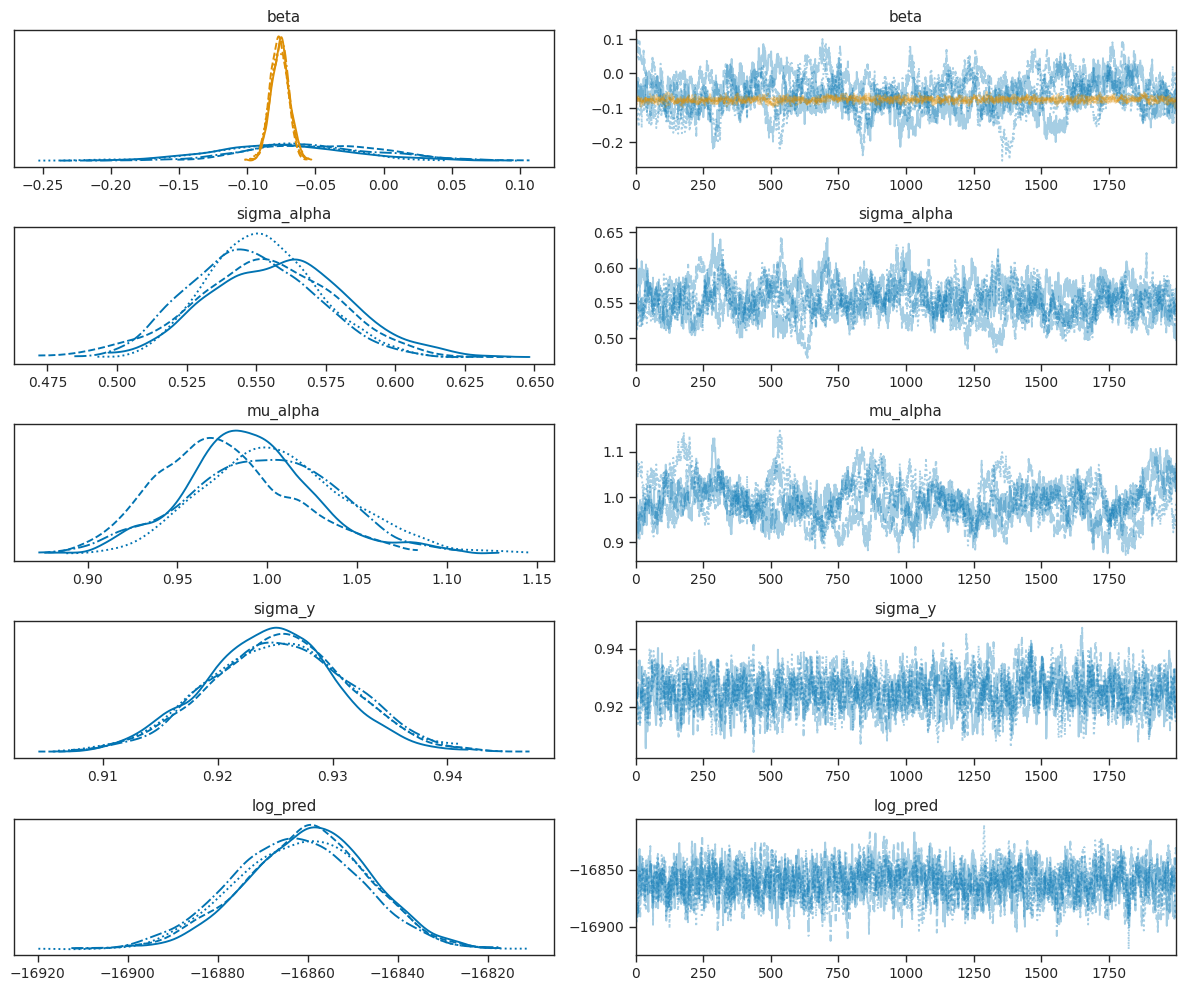

In [11]:
az.plot_trace(idata, var_names=show_vars)
plt.tight_layout()

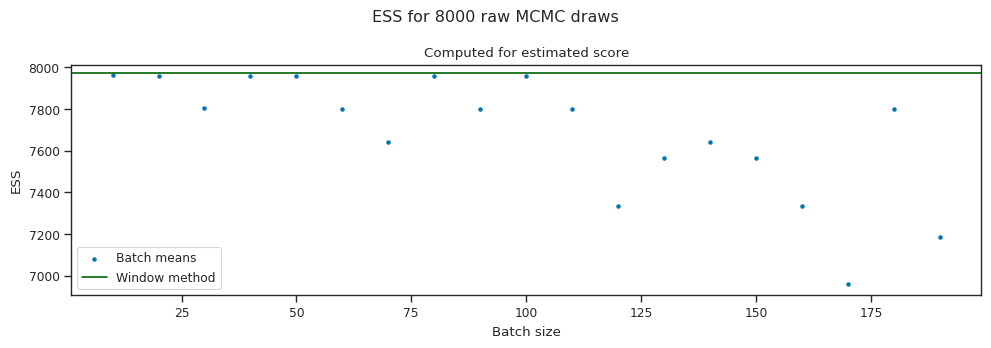

In [12]:
fig, ax = plot_batch_sizes(idata)
fig.savefig('ess_logs_levels_1A.pdf')

In [13]:
del idata

### Model B


#### MCMC

In [14]:
modelB = get_model(model_id=1)
resultsB = full_trace_inference(
    model=modelB,
    fold_id=-1,  # full data
    inference_key=infBkey,
    **common_parameters
)
idata = resultsB.arviz()

<ipython-input-6-c6480afb11aa>:30: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  def make_initial_pos(key: jax.random.KeyArray) -> Theta:


Running window adaptation



Step size = 0.1448, inv mm norm = 5.5762
Warm-up sampling run
Warmup complete in 29.62 sec
Sampling
Done in 7.73 sec


In [15]:
az.summary(idata, var_names=show_vars)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-0.072,0.050,-0.165,0.025,0.004,0.003,172.0,432.0,1.02
beta[1],0.019,0.991,-1.846,1.877,0.032,0.023,965.0,1742.0,1.00
sigma_alpha,0.573,0.027,0.524,0.625,0.002,0.002,129.0,208.0,1.03
mu_alpha,0.963,0.040,0.886,1.032,0.004,0.003,130.0,378.0,1.03
sigma_y,0.930,0.006,0.919,0.941,0.000,0.000,1322.0,2262.0,1.00
log_pred,-16922.794,13.902,-16949.240,-16897.307,0.418,0.295,1113.0,2591.0,1.00


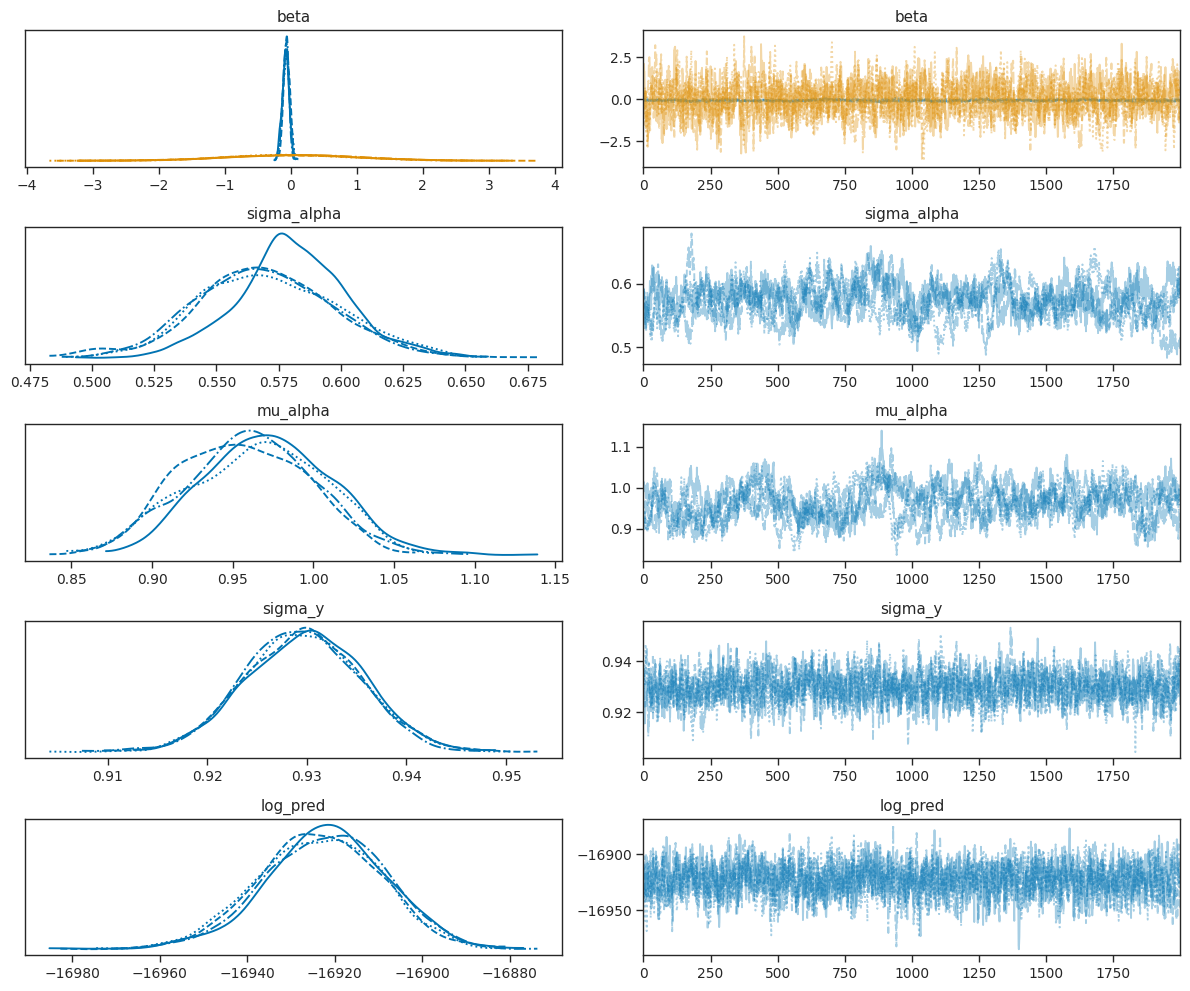

In [16]:
az.plot_trace(idata, var_names=show_vars)
plt.tight_layout()

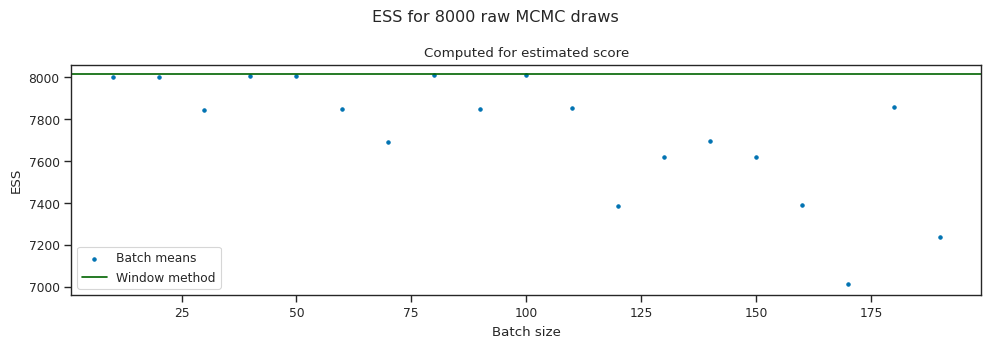

In [17]:
fig, ax = plot_batch_sizes(idata)
fig.savefig('ess_logs_levels_1B.pdf')

In [18]:
del idata

## Parallel cross-validation

In [19]:
res = parallel_cv(
    resultsA,
    resultsB,
    inference_key=infCkey,
    num_folds = J,
    batch_size = 50,
    iter = 2000,
    num_chains = 4,
    warmup_iter = 2000,
    d = 0.01,
)

<ipython-input-3-5e09223d4171>:224: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  def init_one_fold(key: jax.random.KeyArray, fold_id: jax.Array) -> Tuple[ExtendedState, ExtendedState]:


Warmup run
Warmup complete in 45.4 sec
Inference
Inference complete in 42.8 sec
Done


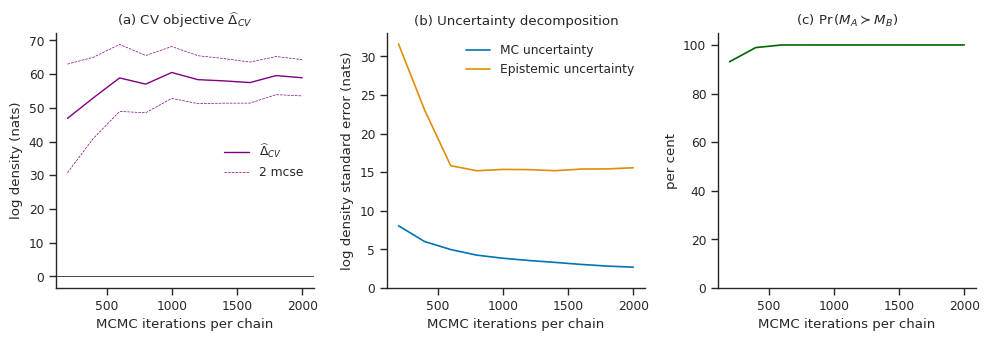

In [20]:
fig, _ = plot_prog3(res, title=r'Progressive diagnostic estimates - home radon example')
fig.savefig('radon_prog.pdf', bbox_inches='tight')

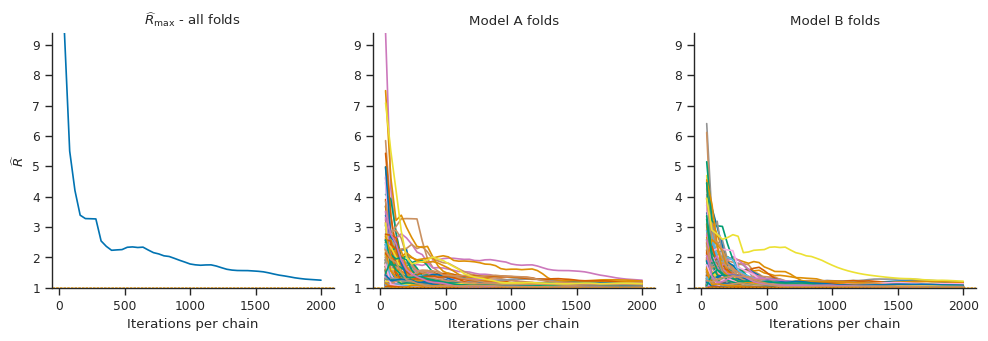

In [21]:
fig, axes = fold_rhat(res['trace'], title=r'Fold $\widehat{R}$s - home radon example')
plt.savefig('radon_rhat.pdf', bbox_inches='tight')

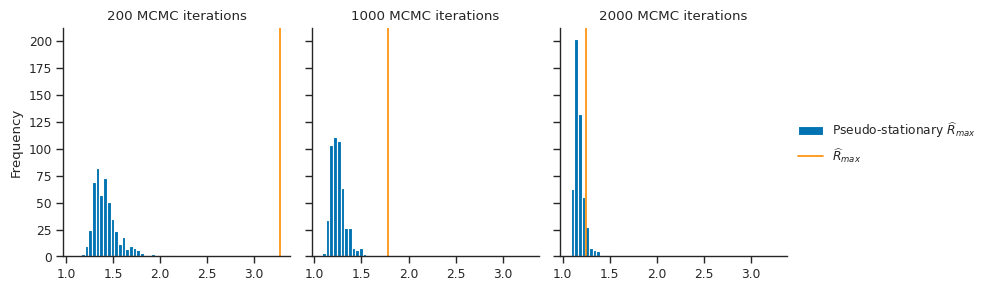

In [26]:
fig, _ = multi_shuff_max(res['trace'], lengths=[200, 1_000, 2_000], sharex=True, ndraws=500)
fig.tight_layout()
fig.savefig('radon_multi_shuffle2.pdf', bbox_inches='tight')

In [27]:
with open('cmp1.pkl', 'wb') as f:
    pickle.dump(res, f)

In [28]:
!zip radon.zip *.pdf

updating: ess_logs_levels_1A.pdf (deflated 31%)
updating: ess_logs_levels_1B.pdf (deflated 31%)
updating: radon_multi_shuffle2.pdf (deflated 39%)
updating: radon_prog.pdf (deflated 38%)
updating: radon_rhat.pdf (deflated 3%)


In [29]:
#@title Environment information

%pip freeze
!lscpu
!cat /proc/cpuinfo

absl-py==1.4.0
aiohttp==3.9.1
aiosignal==1.3.1
alabaster==0.7.13
albumentations==1.3.1
altair==4.2.2
anyio==3.7.1
appdirs==1.4.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array-record==0.5.0
arviz==0.15.1
astropy==5.3.4
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.0
attrs==23.2.0
audioread==3.0.1
autograd==1.6.2
Babel==2.14.0
backcall==0.2.0
beautifulsoup4==4.11.2
bidict==0.22.1
bigframes==0.18.0
blackjax @ git+https://github.com/blackjax-devs/blackjax.git@7100bca3ea39def4bbeaa179a015f67abfa0b1f0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.3.2
bqplot==0.12.42
branca==0.7.0
build==1.0.3
CacheControl==0.13.1
cachetools==5.3.2
catalogue==2.0.10
certifi==2023.11.17
cffi==1.16.0
chardet==5.2.0
charset-normalizer==3.3.2
chex==0.1.7
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpickle==2.2.1
cmake==3.27.9
cmdstanpy==1.2.0
colorcet==3.0.1
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.4
cons==0.4.6
contextlib2==21.6.0
contourpy==1.2.0
c